In [ ]:
import sys, subprocess
# System operations
import os

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
import torch as th

# CityLearn
import citylearn
from citylearn.data import DataSet
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from citylearn.citylearn import CityLearnEnv

# Baseline RL algorithms
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# Utils
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna", "optuna-dashboard"])
print("Optuna installed.")

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [16]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {
    '100%_discharge': -1.0,
    '50%_discharge': -0.5,
    'idle': 0.0,
    '50%_charge': 0.5,
    '100%_charge': 1.0,
}
EVAL_EPISODES = 10

In [17]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

In [18]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity'], drop_predictions=False)


INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


In [19]:
class TrainLoggerCallback(BaseCallback):
    """Logging State, Action, Reward per step and Loss per update phase."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Will collect a dict per env-step
        self.rows = []
        # Loss values and their timesteps (global)
        self.losses = []
        self.loss_timesteps = []
        # Completed episode returns (global list)
        self.episode_rewards = []
        # Placeholders for per-env tracking
        self._current_ep_rewards = []         # sum of rewards in current episode per env
        self._current_ep_counts = []          # episode index per env
        self._current_step_in_episode = []    # step counter (0..T-1) per env

        # DataFrames to populate at end
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        # initialize counters per sub-env
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        # log loss if present
        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        # iterate each sub-env
        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            # flatten observation
            flat = obs.flatten().tolist()
            # build row with metadata
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row.update({
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "step_in_ep": self._current_step_in_episode[idx],
                "action": int(act),
                "reward": float(rew),
                "global_step": step
            })
            row['action_name'] = ACTION_LABELS[int(act)]
            row['action_frac'] = NAME_TO_FRAC[row['action_name']]
            self.rows.append(row)

            # accumulate per-episode reward
            self._current_ep_rewards[idx] += float(rew)
            # increment step in episode
            self._current_step_in_episode[idx] += 1

            # if end of episode for this env
            if done:
                # log reward and finalize episode
                print(f"Env {idx} Episode {self._current_ep_counts[idx]} done at global step {step}, total reward: {self._current_ep_rewards[idx]:.3f}")
                self.episode_rewards.append(self._current_ep_rewards[idx])
                # reset for next episode
                self._current_ep_rewards[idx] = 0.0
                self._current_ep_counts[idx] += 1
                self._current_step_in_episode[idx] = 0

        return True

    def _on_training_end(self) -> None:
        # build full-step DataFrame
        self.df = pd.DataFrame(self.rows)
        # build episodes summary DataFrame
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

In [20]:
class DiscretizeActionWrapper(gym.ActionWrapper):
    """Map Discrete(n_bins) -> Box(low, high, shape=(1,)) for 1-D continuous action envs."""
    def __init__(self, env: gym.Env, n_bins: int = 5):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.Box), "Expect Box action space."
        assert env.action_space.shape == (1,), "Use single-building (1-D) action."
        self.low = float(env.action_space.low[0])
        self.high = float(env.action_space.high[0])
        self.n_bins = int(n_bins)
        # Create bin centers in [low, high]
        self.bin_vals = np.linspace(self.low, self.high, self.n_bins, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(self.n_bins)

    def action(self, act: int):
        # Map int -> 1-D Box vector
        val = self.bin_vals[int(act)]
        return np.array([val], dtype=np.float32)

In [21]:
import copy, os, time, json, pickle
import numpy as np
import pandas as pd
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

train_env = CityLearnEnv(schema_1b, central_agent=True)
train_env = NormalizedObservationWrapper(train_env)
train_env = StableBaselines3Wrapper(train_env)
# Discretize action space for DQN:
train_env = DiscretizeActionWrapper(train_env, n_bins=5)
train_env = Monitor(train_env)

train_callback = TrainLoggerCallback()

T = train_env.unwrapped.time_steps  # 2208
num_episodes = 10
TOTAL_TIMESTEPS = num_episodes * T

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_starts=1000,
    #learning_rate=3e-4,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[256, 256, 256], activation_fn=th.nn.ReLU),
)
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save("dqn_01")
try:
    model.save_replay_buffer("dqn_01_replaybuffer.pkl")
except Exception as e:
    print("Replay buffer not saved:", e)
print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
train_callback.df.to_csv("train_steps.csv", index=False)
train_callback.ep_df.to_csv("train_episodes.csv", index=False)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_14-10-49'
Using cuda device
Wrapping the env in a DummyVecEnv.
Env 0 Episode 1 done at global step 2207, total reward: -288.099
Env 0 Episode 2 done at global step 4414, total reward: -267.080
Env 0 Episode 3 done at global step 6621, total reward: -269.420
Env 0 Episode 4 done at global step 8828, total reward: -267.133
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | -273     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19       |
|    time_elapsed     | 449      

In [22]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)

model = DQN.load("dqn_01", env=eval_env)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_14-30-19'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Eval: collect discrete actions and rewards per step (overwrites simple eval_dqn)
def eval_dqn(model, eval_env, schema, episodes=3, deterministic=True):
    """Deterministic evaluation that returns actions/rewards for plotting."""
    ep_lengths, actions_disc_list, step_rewards_all = [], [], []
    for _ in range(episodes):
        obs, _ = eval_env.reset()
        done = False
        ep_actions, ep_rewards = [], []
        while not done:
            act_disc, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = eval_env.step(act_disc)
            done = bool(terminated or truncated)
            ep_actions.append(int(act_disc))
            ep_rewards.append(float(r))
        ep_lengths.append(len(ep_rewards))
        actions_disc_list.append(np.array(ep_actions, dtype=int))
        step_rewards_all.extend(ep_rewards)

    # Pricing for Building_1 
    building_name = 'Building_1'
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc = pd.read_csv(price_path)
    T = len(prc)

    return {
        'ep_lengths': np.array(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.array(step_rewards_all, dtype=float),
        'price_df': prc,
        'episode_len': T,
        'building_name': building_name,
    }

# Run eval and store results
eval_results = eval_dqn(model, eval_env, schema_eval, episodes=10, deterministic=True)
print('Eval episodes:', len(eval_results['ep_lengths']), 'total steps:', len(eval_results['step_rewards']))

# Save eval results
eval_path = "eval_results.pkl"
with open(eval_path, "wb") as f:
    pickle.dump(eval_results, f)

Eval episodes: 5 total steps: 11035


In [29]:
# Optuna objective for DQN on CityLearn (single building, same wrappers)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

# Reuse your DiscretizeActionWrapper, NormalizedObservationWrapper, StableBaselines3Wrapper, CityLearnEnv
# Assumes 'schema', 'ROOT_DIR', 'one_building' already exist from your previous cells.

ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}"
STUDY_NAME  = "dqn_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space
    lr      = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma   = trial.suggest_float("gamma", 0.90, 0.9999)
    buffer  = trial.suggest_int("buffer_size", 50_000, 200_000, step=25_000)
    batch   = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    tau     = trial.suggest_float("tau", 0.005, 1.0, log=True)
    tgt_upd = trial.suggest_int("target_update_interval", 250, 5000, step=250)
    train_f = trial.suggest_int("train_freq", 1, 8)
    grad_st = trial.suggest_int("gradient_steps", 1, 4)
    expl_fr = trial.suggest_float("exploration_fraction", 0.05, 0.4)
    expl_fin= trial.suggest_float("exploration_final_eps", 0.01, 0.1)
    starts  = trial.suggest_int("learning_starts", 500, 5000, step=500)
    arch    = trial.suggest_categorical("net_arch", [(256,256), (256,256,256), (512,512)])

    # Build train/eval envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # Episodes per trial (keep small for speed)
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = DQN(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        buffer_size=buffer,
        batch_size=batch,
        tau=tau,
        target_update_interval=tgt_upd,
        train_freq=train_f,
        gradient_steps=grad_st,
        exploration_fraction=expl_fr,
        exploration_final_eps=expl_fin,
        learning_starts=starts,
        verbose=0,
        policy_kwargs=dict(net_arch=list(arch), activation_fn=th.nn.ReLU),
        device="auto",
    )

    # Evaluation + pruning during training
    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=T//2, eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        # Ensure envs are closed
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # Final score
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    # Save best-so-far model snapshot
    trial.set_user_attr("final_mean_reward", score)
    return score

# Create/continue a study
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=0),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1),
)
print("Study ready:", STUDY_NAME, STORAGE_URL)

[I 2025-08-26 14:48:31,770] Using an existing study with name 'dqn_citylearn' instead of creating a new one.


Study ready: dqn_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_dqn.db


In [33]:
N_TRIALS = 1  # increase as needed
study.optimize(objective, n_trials=N_TRIALS, gc_after_trial=True)
print("Done. Trials now:", len(study.trials))

/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 256) which is of type tuple.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 256, 256) which is of type tuple.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (512, 512) which is of type tuple.
  warnings.warn(message)


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_15-05-05'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_15-05-06'


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_15-33-26'


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-08-26 15:39:03,126] Trial 0 finished with value: -264.9435168108443 and parame

Done. Trials now: 1


Loaded cached eval_results.


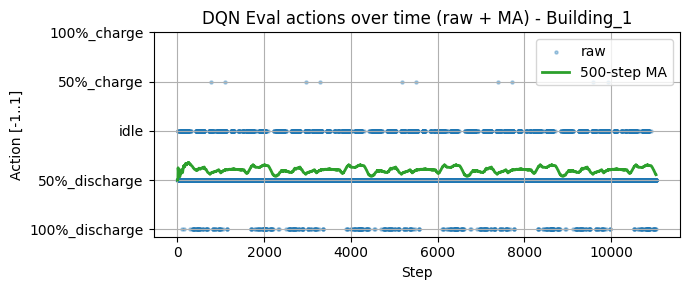

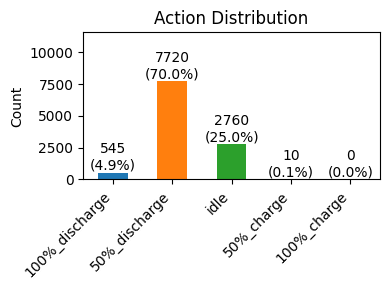

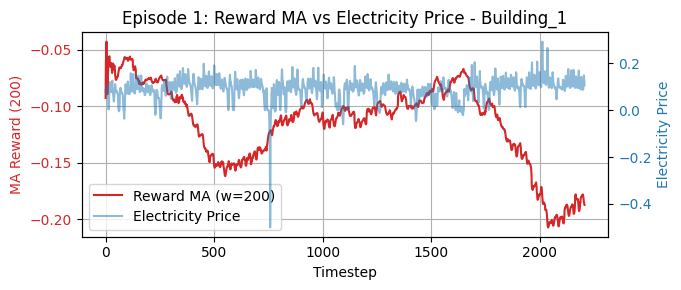

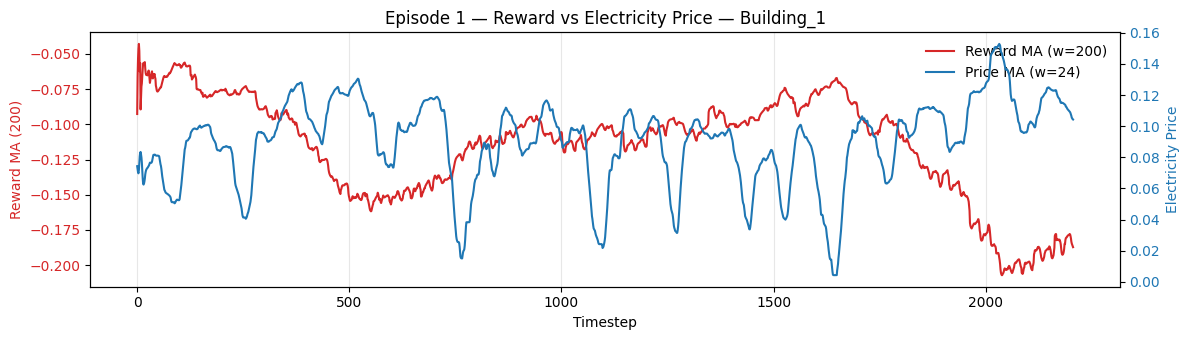

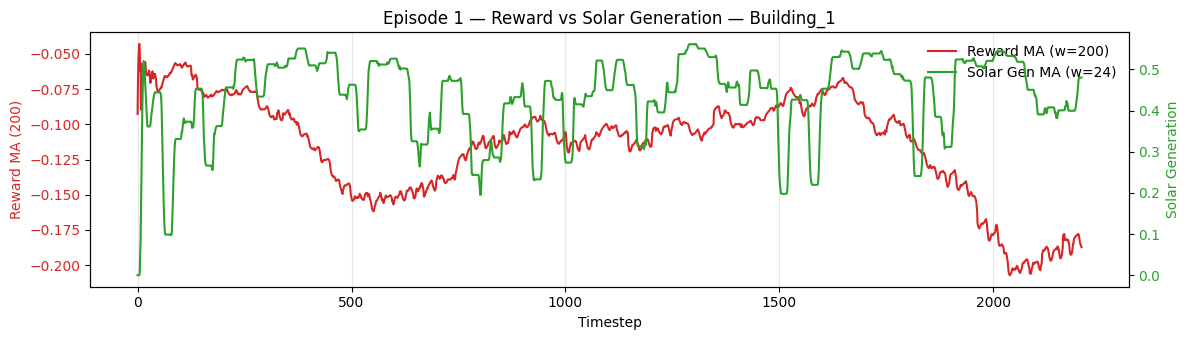

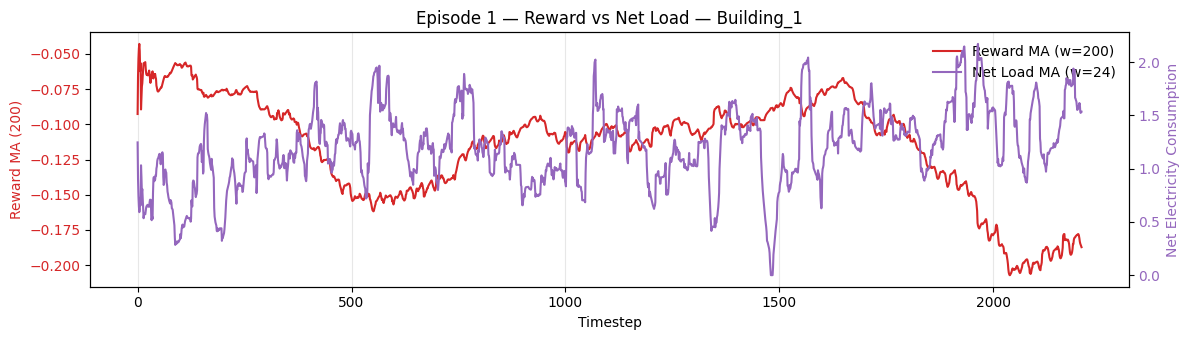

In [ ]:
# Plots based on eval results (actions + rewards)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, copy, pickle
"""
SAVE_DIR = os.path.join(os.getcwd(), "artifacts")
model_path = os.path.join(SAVE_DIR, "dqn_model.zip")
rb_path    = os.path.join(SAVE_DIR, "dqn_replay_buffer.pkl")
eval_path  = os.path.join(SAVE_DIR, "eval_results.pkl")

# Recreate the SAME env stack as training/eval
schema_1b = dict(schema)
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}

train_env = CityLearnEnv(schema_1b, central_agent=True)
train_env = NormalizedObservationWrapper(train_env)
train_env = StableBaselines3Wrapper(train_env)
train_env = DiscretizeActionWrapper(train_env, n_bins=5)

model = DQN.load(model_path, env=train_env, device="auto")
try:
    model.load_replay_buffer(rb_path)
except Exception as e:
    print("Replay buffer not loaded:", e)
"""
# Load cached eval results (skip re-eval)
if os.path.exists(eval_path):
    with open(eval_path, "rb") as f:
        eval_results = pickle.load(f)
    print("Loaded cached eval_results.")
else:
    schema_eval = copy.deepcopy(schema_1b)
    eval_env = CityLearnEnv(schema_eval, central_agent=True)
    eval_env = NormalizedObservationWrapper(eval_env)
    eval_env = StableBaselines3Wrapper(eval_env)
    eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)
    eval_results = eval_dqn(model, eval_env, schema_eval, episodes=5, deterministic=True)
    with open(eval_path, "wb") as f:
        pickle.dump(eval_results, f)
    print("Computed and cached eval_results.")

# Unpack eval results
ep_lengths   = eval_results['ep_lengths']
actions_disc = np.concatenate(eval_results['actions_disc_list'], axis=0)
step_rewards = eval_results['step_rewards']
prc          = eval_results['price_df']
T            = eval_results['episode_len']
building_name= eval_results['building_name']

# Map discrete ids -> fraction [-1,-0.5,0,0.5,1] consistent with ACTION_LABELS order
int_to_frac = {0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}
actions_frac = pd.Series(actions_disc).map(int_to_frac).to_numpy()

ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(len(actions_frac))

# ----- Plot 1: Actions over time (raw + MA) -----
window = 500
act_ma = pd.Series(actions_frac).rolling(window, min_periods=1).mean().to_numpy()
plt.figure(figsize=(7,3))
plt.scatter(hour_index, actions_frac, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'DQN Eval actions over time (raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action [-1..1]'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (5-bin) -----
counts = pd.Series(actions_disc).value_counts().reindex(range(5)).fillna(0).astype(int)
plt.figure(figsize=(4,3))
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()

# ----- Plot 3: Episode 1 Reward MA vs Electricity Price -----
ep1_len = int(ep_lengths[0])
ep1_rewards = step_rewards[:ep1_len]
window_r = 200
ep1_reward_ma = pd.Series(ep1_rewards).rolling(window_r, min_periods=1).mean().to_numpy()
fig, ax1 = plt.subplots(figsize=(7,3))
ax1.plot(np.arange(ep1_len), ep1_reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_ylabel(f'MA Reward ({window_r})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Timestep'); ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(prc.index[:ep1_len], prc['electricity_pricing'][:ep1_len], color='C0', alpha=0.5, label='Electricity Price')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left')
plt.title(f'Episode 1: Reward MA vs Electricity Price - {building_name}')
plt.tight_layout(); plt.show()

# ----- Plot 4: Episode 1 Reward MA vs Net Load -----

# Combined Episode 1 plots: Reward vs Price, Reward vs Solar, Reward vs Net Load (separate figures)

def unwrap_to_citylearn(env):
    """Traverse wrappers and return the inner CityLearnEnv."""
    seen = set()
    cur = env
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")


def eval_episode_collect_four(model, env, building_name="Building_1", deterministic=True):
    base = unwrap_to_citylearn(env)

    # Building index
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # Observation name -> index
    obs_names = getattr(base, 'observation_names', None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_names_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_names_b)}

    # Indices (with fallback for net load)
    i_price = name_to_idx.get('electricity_pricing')
    i_solar = name_to_idx.get('solar_generation')
    i_nl    = name_to_idx.get('net_electricity_consumption')
    if i_nl is None:
        i_nl = name_to_idx.get('net_electricity_consumption_without_storage')

    missing = [k for k, i in {
        'electricity_pricing': i_price,
        'solar_generation': i_solar,
        'net_electricity_consumption(_without_storage)': i_nl,
    }.items() if i is None]
    if missing:
        raise KeyError(f"Missing observations: {missing}\nAvailable: {obs_names_b}")

    # Run one episode and collect series
    obs, _ = env.reset()
    done = False
    r_list, p_list, n_list, s_list = [], [], [], []
    while not done:
        act, _ = model.predict(obs, deterministic=deterministic)
        obs, r, terminated, truncated, info = env.step(act)
        done = bool(terminated or truncated)

        raw = base.observations[b_idx]
        r_list.append(float(r))
        p_list.append(float(raw[i_price]))
        n_list.append(float(raw[i_nl]))
        s_list.append(float(raw[i_solar]))

    return {
        'reward': np.asarray(r_list, dtype=float),
        'price':  np.asarray(p_list, dtype=float),
        'net':    np.asarray(n_list, dtype=float),
        'solar':  np.asarray(s_list, dtype=float),
        'building_name': building_name
    }

# Collect episode 1 series (deterministic)
series = eval_episode_collect_four(model, eval_env, building_name="Building_1", deterministic=True)

# Optional smoothing
window_r = 200
window_x = 24
reward_ma = pd.Series(series['reward']).rolling(window_r, min_periods=1).mean().to_numpy()
price_ma  = pd.Series(series['price']).rolling(window_x, min_periods=1).mean().to_numpy()
net_ma    = pd.Series(series['net']).rolling(window_x, min_periods=1).mean().to_numpy()
solar_ma  = pd.Series(series['solar']).rolling(window_x, min_periods=1).mean().to_numpy()

t = np.arange(len(reward_ma))


# 1) Reward vs Price
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_r})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
ax2.set_ylabel('Electricity Price', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f"Episode 1 — Reward vs Electricity Price — {series['building_name']}")
plt.tight_layout(); plt.show()


# 2) Reward vs Solar Generation
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_r})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
ax2.set_ylabel('Solar Generation', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f"Episode 1 — Reward vs Solar Generation — {series['building_name']}")
plt.tight_layout(); plt.show()


# 3) Reward vs Net Load
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_r})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
ax2.set_ylabel('Net Electricity Consumption', color='C4')
ax2.tick_params(axis='y', labelcolor='C4')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f"Episode 1 — Reward vs Net Load — {series['building_name']}")
plt.tight_layout(); plt.show()

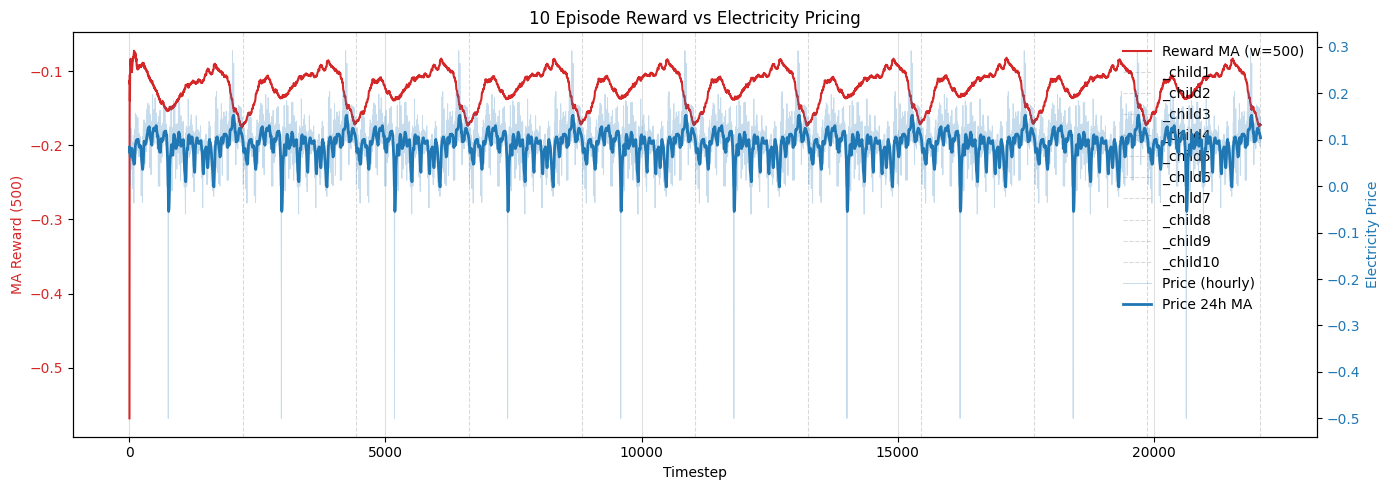

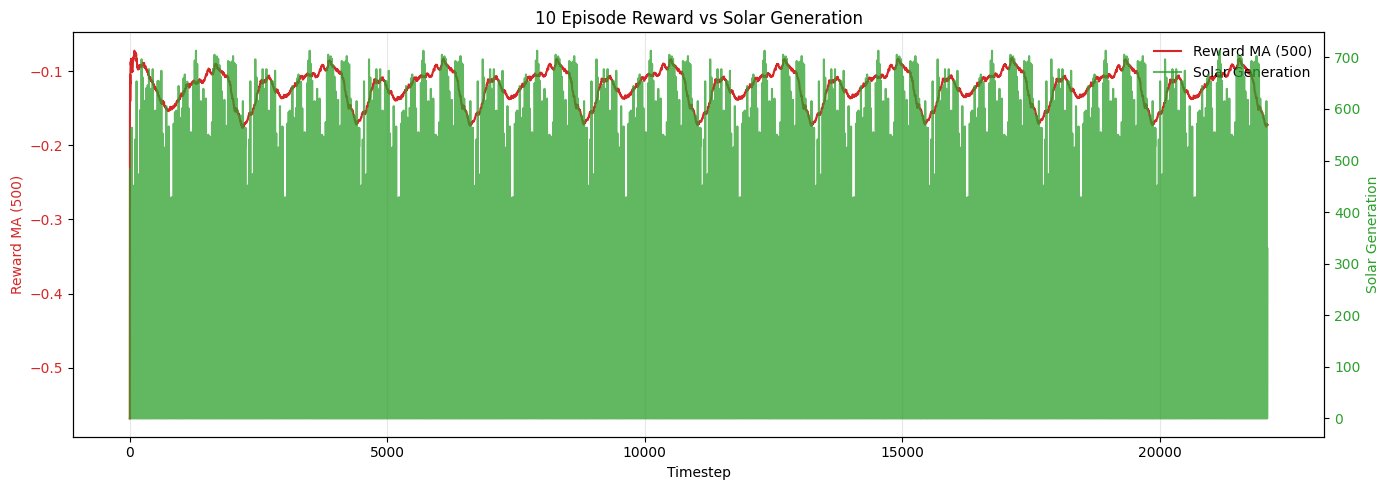

KeyboardInterrupt: 

In [ ]:
# Full-horizon Reward (env 0) vs Electricity Pricing (tiled across episodes)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from utils.plotting_utils import set_full_month_formatter
from citylearn.citylearn import CityLearnEnv

# Tunable parameters
window_reward = 500        # rolling window (hours) for reward smoothing
window_price_ma = 24       # rolling window (hours) for price smoothing
plot_hourly_price = True   # set False to hide raw noisy price
mark_episode_boundaries = True

# Episode length (hours) assumed constant
T = len(prc)   # == 2208

# Filter env 0 logs and order
df0 = train_callback.df[train_callback.df['env_id'] == 0].copy()
df0 = df0.sort_values(['episode', 'step_in_ep'])

# Continuous hour index across episodes
df0['hour_index'] = (df0['episode'] - 1) * T + df0['step_in_ep']

# Rolling reward smoothing
df0['reward_ma'] = df0['reward'].rolling(window_reward, min_periods=1).mean()

# Total hours recorded
n_hours_total = int(df0['hour_index'].max() + 1)

# Tile pricing to cover the whole training horizon (episodes replay same period)
n_repeats = int(np.ceil(n_hours_total / T))
price_tiled = np.tile(prc['electricity_pricing'].values, n_repeats)[:n_hours_total]
price_series = pd.Series(price_tiled)

# Smooth price
price_ma = price_series.rolling(window_price_ma, min_periods=1).mean()

# Align to df0 length (in case of partial last hour)
price_aligned = price_series.iloc[:len(df0)].values
price_ma_aligned = price_ma.iloc[:len(df0)].values

# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df0['hour_index'], df0['reward_ma'],
         color='C3', label=f'Reward MA (w={window_reward})')
# (Optional) Convert x-axis to day labels instead of hours:
def hours_to_month(x, pos): return f'M{(int(x)//(2208//3))%3 + 1}'

#ax1.xaxis.set_major_locator(mticker.MaxNLocator(29))
#ax1.xaxis.set_major_formatter(mticker.FuncFormatter(hours_to_month))
#set_full_month_formatter(ax1)

ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'MA Reward ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.4)


fig.canvas.draw_idle()

ax2 = ax1.twinx()
if plot_hourly_price:
    ax2.plot(df0['hour_index'], price_aligned,
             color='C0', alpha=0.25, linewidth=0.7, label='Price (hourly)')
ax2.plot(df0['hour_index'], price_ma_aligned,
         color='C0', linewidth=2, label=f'Price {window_price_ma}h MA')
ax2.set_ylabel('Electricity Price', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

# Episode boundary markers
if mark_episode_boundaries:
    last_episode = int(df0['episode'].max())
    for ep in range(2, last_episode + 1):
        x = (ep - 1) * T
        ax1.axvline(x, color='k', linestyle='--', alpha=0.15, linewidth=0.8)

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=False)

plt.title('10 Episode Reward vs Electricity Pricing')
plt.tight_layout()
plt.show()


# ------------------------------------
# Solar generation

# Copy logged steps
df_all = train_callback.df.copy()

# Determine episodes per env (assumes uniform)
episodes_per_env = df_all.groupby('env_id')['episode'].max().min()
T = train_env.unwrapped.time_steps  # episode length (hours)
num_envs = df_all['env_id'].nunique()
TotalEpisodes = num_envs * episodes_per_env  # expected 30

# Create a synthetic global episode index: env0 1..N, env1 N+1..2N, etc.
df_all['global_episode'] = df_all['env_id'] * episodes_per_env + df_all['episode']

# Global hour index across all 30 episodes
df_all['global_hour_index'] = (df_all['global_episode'] - 1) * T + df_all['step_in_ep']

# Sort by global hour to ensure monotonic order
df_all = df_all.sort_values('global_hour_index')

# Reward moving average (window 500 hours)
window_reward = 500
df_all['reward_ma500'] = df_all['reward'].rolling(window_reward, min_periods=1).mean()

building_name = 'Building_1'
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(ROOT_DIR, filename)
building_data = pd.read_csv(filepath)
bld = building_data.copy()


# Tile solar generation across all global episodes (assumes each episode replays same base horizon)
solar_vals = np.tile(bld['solar_generation'].values, TotalEpisodes)
needed_len = int(df_all['global_hour_index'].max() + 1)
solar_vals = solar_vals[:needed_len]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df_all['global_hour_index'], df_all['reward_ma500'], color='C3', label=f'Reward MA ({window_reward})')
ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Timestep')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(range(needed_len), solar_vals, color='C2', alpha=0.75, label='Solar Generation')
ax2.set_ylabel('Solar Generation', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

# Legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=False)

plt.title('10 Episode Reward vs Solar Generation')
plt.tight_layout()
plt.show()

# -----------------------
# SOC & net load

# Collect SoC/net_load/price for a selected building during evaluation and plot vs price.

building_name = eval_results['building_name'] if 'eval_results' in globals() else 'Building_1'
state_eval = eval_collect_state_series(model, eval_env, building_name=building_name, episodes=EVAL_EPISODES, deterministic=False)

# Flatten across eval episodes
soc_all   = np.concatenate(state_eval['soc_list'], axis=0)
net_all   = np.concatenate(state_eval['net_list'], axis=0)
price_all = np.concatenate(state_eval['price_list'], axis=0)
solar_all = np.concatenate(state_eval['solar_list'], axis=0)
ep_lengths = state_eval['ep_lengths']
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(len(soc_all))

# Plot 3: SoC vs Price (full horizon, smoothed)
window_soc = 24
window_prc = 24
soc_ma   = pd.Series(soc_all).rolling(window_soc, min_periods=1).mean().to_numpy()
price_ma = pd.Series(price_all).rolling(window_prc, min_periods=1).mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(hour_index, soc_ma, color='C2', label=f'SoC {window_soc}h MA')
ax1.set_ylabel('Electrical Storage SoC', color='C2'); ax1.tick_params(axis='y', labelcolor='C2')
ax1.set_xlabel('Step'); ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(hour_index, price_ma, color='C0', lw=2, label=f'Price {window_prc}h MA')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')

for off in ep_offsets[1:]:
    ax1.axvline(off, color='k', linestyle='--', alpha=0.15, linewidth=0.8)

lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f"SoC vs Price (eval, {state_eval['building_name']})")
plt.tight_layout(); plt.show()

# Plot 4: Net Load vs Price (full horizon, smoothed)
window_net = 24
net_ma   = pd.Series(net_all).rolling(window_net, min_periods=1).mean().to_numpy()
price_ma = pd.Series(price_all).rolling(window_prc, min_periods=1).mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(hour_index, net_ma, color='C3', label=f'Net Load {window_net}h MA')
ax1.set_ylabel('Net Electricity Consumption', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Step'); ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(hour_index, price_ma, color='C0', lw=2, label=f'Price {window_prc}h MA')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')

for off in ep_offsets[1:]:
    ax1.axvline(off, color='k', linestyle='--', alpha=0.15, linewidth=0.8)

lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f"Net Load vs Price (eval, {state_eval['building_name']})")
plt.tight_layout(); plt.show()

print(f"Episodes per env: {episodes_per_env}, Env count: {num_envs}, Total synthetic global episodes: {TotalEpisodes}")